In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc_absolute
%store -r Y_relative_footsteps_acc_absolute
print(X_relative_footsteps_acc_absolute.shape)
print(Y_relative_footsteps_acc_absolute.shape)

(9780, 28)
(9780, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_relative_footsteps_acc_absolute[:, 23] == 1)[0]
X_relative_footsteps_acc_absolute_RL_swing = X_relative_footsteps_acc_absolute[idxs]
Y_relative_footsteps_acc_absolute_RL_swing = Y_relative_footsteps_acc_absolute[idxs]

## Predict RL foot -> x

In [8]:
X_relative_footsteps_acc_absolute_RL_swing[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

In [9]:
X_relative_footsteps_acc_absolute_RL_swing[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

### Linear Regression

In [18]:
# Input
X = np.hstack((X_relative_footsteps_acc_absolute_RL_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_absolute_RL_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_absolute_RL_swing[:, 3:9], # commanded velocity command
               X_relative_footsteps_acc_absolute_RL_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_absolute_RL_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_absolute_RL_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_absolute_RL_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_absolute_RL_swing[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8457077385318661
RMSE:  0.004247588606469402
The lowest error is:  6.224482572148027e-07
The highest error is:  0.020777626157175155
The avg. error is:  0.0031184783209037064


In [19]:
model_rl_relative_swinging_x.coef_

array([[ 0.04476194, -0.01580006, -0.06352495,  0.00278718,  0.00561405,
        -0.02228349, -0.13120207,  0.02592039,  0.00579645,  0.00647071,
         0.00106013, -0.00304598, -0.54001061, -0.17243847, -0.28179652,
        -0.19093308, -0.01642727,  0.24672256,  0.58195364,  0.25602468]])

In [20]:
model_rl_relative_swinging_x.intercept_

array([0.32551454])

Text(0, 0.5, 'Predictions')

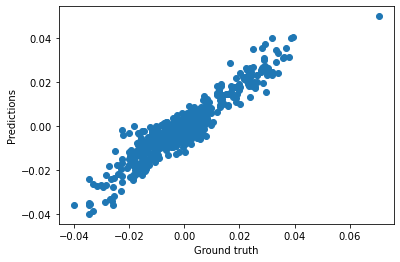

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#%store model_rl_relative_swinging_x

In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [24]:
# Save model
#joblib.dump(model_rl_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rl_relative_swinging_x.sav")

### Predict RL foot -> y

In [27]:
# Input
X = np.hstack((X_relative_footsteps_acc_absolute_RL_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_absolute_RL_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_absolute_RL_swing[:, 3:9], # commanded velocity command
               X_relative_footsteps_acc_absolute_RL_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_absolute_RL_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_absolute_RL_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_absolute_RL_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_absolute_RL_swing[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9412207286205163
RMSE:  0.0037721303295126197
The lowest error is:  8.289509821624019e-08
The highest error is:  0.03849303323508026
The avg. error is:  0.002568120737019269


In [28]:
model_rl_relative_swinging_y.coef_

array([[-1.68690166e-02,  2.73038271e-02,  7.81023867e-02,
        -4.60286229e-05,  2.78327872e-03,  3.41755255e-02,
        -2.02517670e-02, -1.39881555e-01,  1.46411543e-03,
         1.82165000e-02,  2.05150792e-02,  4.00658246e-02,
         3.87069073e-02,  9.45557587e-02,  3.49018682e-02,
        -5.30972187e-02, -1.38802050e-01, -4.43088221e-01,
         2.15749997e-01,  6.31968191e-02]])

In [29]:
model_rl_relative_swinging_y.intercept_

array([0.0666916])

Text(0, 0.5, 'Predictions')

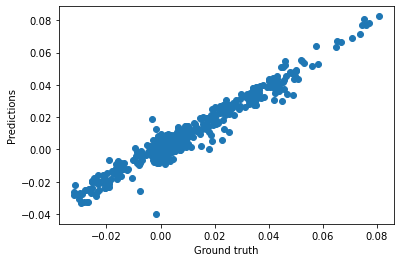

In [30]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [73]:
#%store model_rl_relative_swinging_y

In [74]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [75]:
# Save model
#joblib.dump(model_rl_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rl_relative_swinging_y.sav")